In [1]:
# Package Imports
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline

# Standardizing
from sklearn.preprocessing import RobustScaler

# PCA
from sklearn.decomposition import PCA

# Cleaning

In [2]:
# Data import
df = pd.read_stata("../data/raw/ESS9e03_1.dta", convert_categoricals = False)

# Subsetting Columns

All columns of the themes on Media & Social Trust, Politics, Human Values, Justice & Fairness, and Timing of Life will be selected. Features link political, social, and moral views to try to cluster the data.

First array is for Media and Politics themes combined. Second array is for Human Values and Justice & Fairness. Third is for Timing of Life

In [3]:
# Creates an array of column indicies to extract
cols = np.concatenate([np.arange(6, 114), np.arange(497, 551), np.arange(200, 236)])

# Selects only relevant columns, saves as a new object to preserve original data
df_final = df.iloc[:, cols]

In [4]:
df_final.head()

,nwspol,netusoft,netustm,ppltrst,pplfair,pplhlp,polintr,psppsgva,actrolga,psppipla,...,tygrtr,tolvpnt,tochld,towkht,anvcld,alvgptn,acldnmr,aftjbyc,advcyc,plnftr
0,60.0,5.0,180.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,...,111.0,30.0,45.0,0.0,4.0,4.0,4.0,4.0,4.0,2.0
1,10.0,5.0,20.0,7.0,8.0,7.0,2.0,3.0,2.0,3.0,...,55.0,30.0,45.0,60.0,4.0,4.0,4.0,2.0,2.0,4.0
2,60.0,4.0,180.0,5.0,7.0,7.0,4.0,2.0,1.0,3.0,...,0.0,0.0,55.0,57.0,3.0,3.0,3.0,3.0,3.0,2.0
3,45.0,5.0,120.0,3.0,9.0,5.0,3.0,2.0,2.0,3.0,...,45.0,30.0,65.0,NaN,3.0,4.0,4.0,3.0,4.0,1.0
4,30.0,1.0,NaN,5.0,8.0,4.0,2.0,1.0,1.0,1.0,...,20.0,25.0,40.0,60.0,2.0,2.0,2.0,2.0,2.0,7.0


## Problematic Values

Some columns contain responses which are difficult to extract/replace due to the very nature of these questions. In essence, they mix quantitative and qualitative responses. As such, these columns are removed in their entirety as opposed to attempting to fix them.

Checking for Refusal, Don't Know, and No Answer values which would show as some number of 7's, 8's, or 9's. For example, 77, 88, or 99 for a scale of 0-10

In [5]:
# Check for non-response values in each of the themes
df_final[["nwspol", "polintr", "ipcrtiv", "frprtpl", "tygrtr"]].describe()

,nwspol,polintr,ipcrtiv,frprtpl,tygrtr
count,48947.000000,49421.000000,48365.000000,46833.000000,45066.000000
mean,85.477394,2.661743,2.691988,2.719300,49.388808
std,137.591927,0.924052,1.268780,1.050992,19.650299
min,0.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2.000000,2.000000,2.000000,45.000000
50%,60.000000,3.000000,2.000000,3.000000,50.000000
75%,90.000000,3.000000,3.000000,3.000000,60.000000
max,1440.000000,4.000000,6.000000,5.000000,222.000000


There do not appear to be non-response values, but there are issues with outliers and mixed categorical/numerical variables. 

**Media & Social Trust**

Some values here are extreme outliers, such as 1440 minutes of news per week, whereas the mean is 60. These values will make StandardScaler much less effective and may need to be scaled using RobustScaler.

**Timing of Life**

`tygrtr` is a variable for the "appropriate age to retire permanently". Values of 000 mean "never too young", 111 mean "should never retire permanently", and 222 mean "should never be in paid work". This while there are values representing actual ages. This makes these variables mixed categorical/numerical. 

To fix this, many columns from the split ballot for Timing of Life will be removed. This goes from `admge` to `towkht`. `lvpntyr` will also be removed as it contains years of "0000" and "1111" for certain categorical responses.

In [6]:
# Finding locations
start = df_final.columns.get_loc("admge")
end = df_final.columns.get_loc("towkht") + 1
lvpntyr = df_final.columns.get_loc("lvpntyr")

In [7]:
# Removes problem questions
drop_cols = np.concatenate([np.arange(start,end), [lvpntyr]])
df_final.drop(df_final.columns[drop_cols], axis = 1, inplace = True)

C:\Users\Matt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Reordering Responses

Some responses have the lowest values as the highest agreement/most positive view. These are flipped for interpretability.

The human values variables are ordered from 1-6, with 1 being most like oneself. This is counter to the rest of the data and will therefore be flipped.

In [8]:
# Changes human values data to make higher values mean more in line with that value
human_vals = df_final.iloc[:, df_final.columns.get_loc("ipcrtiv"):df_final.columns.get_loc("impfun")+1]

for col in human_vals.columns:
    human_vals[col] = np.where(human_vals[col] == 1, 6, 
                               np.where(human_vals[col] == 2, 5, 
                                        np.where(human_vals[col] == 3, 4, 
                                                 np.where(human_vals[col] == 4, 3, 
                                                          np.where(human_vals[col] == 5, 2, 
                                                                   np.where(human_vals[col] == 6, 1, human_vals[col]))))))

<ipython-input-8-ed516b794a95>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_vals[col] = np.where(human_vals[col] == 1, 6,
<ipython-input-8-ed516b794a95>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_vals[col] = np.where(human_vals[col] == 1, 6,
<ipython-input-8-ed516b794a95>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [9]:
# Replaces with reordered features
df_final.iloc[:, df_final.columns.get_loc("ipcrtiv"):df_final.columns.get_loc("impfun")+1] = human_vals

C:\Users\Matt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-9-f3c6368aad2f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.iloc[:, df_final.columns.get_loc("ipcrtiv"):df_final.columns.get_loc("impfun")+1] = human_vals


Similar to the human values data, data on immigrants is from 1 to 4 where 4 is strongly disagree. This is true for a few values prior to information on immigrants as well. These will be flipped too.

In [10]:
# Changes human values data to make higher values mean more in line with that value
start = df_final.columns.get_loc("imsmetn")
end = df_final.columns.get_loc("impcntr") + 1

columns = np.concatenate([np.arange(start, end)])

immigrants = df_final.iloc[:, columns]

for col in immigrants.columns:
    immigrants[col] = np.where(immigrants[col] == 1, 4, 
                               np.where(immigrants[col] == 2, 3, 
                                        np.where(immigrants[col] == 3, 2, 
                                                 np.where(immigrants[col] == 4, 1, immigrants[col]))))

<ipython-input-10-238609b507ca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  immigrants[col] = np.where(immigrants[col] == 1, 4,
<ipython-input-10-238609b507ca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  immigrants[col] = np.where(immigrants[col] == 1, 4,
<ipython-input-10-238609b507ca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [11]:
# Replaces with reordered features
df_final.iloc[:, df_final.columns.get_loc("imsmetn"):df_final.columns.get_loc("impcntr")+1] = immigrants

C:\Users\Matt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-3a2f4b021ccf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.iloc[:, df_final.columns.get_loc("imsmetn"):df_final.columns.get_loc("impcntr")+1] = immigrants


In [12]:
# Changes human values data to make higher values mean more in line with that value
start_1 = df_final.columns.get_loc("gincdif")
end_1 = df_final.columns.get_loc("hmsacld") + 1
start_2 = df_final.columns.get_loc("sofrdst")
end_2 = df_final.columns.get_loc("pcmpinj") + 1

columns = np.concatenate([np.arange(start_1, end_1), np.arange(start_2, end_2)])

five = df_final.iloc[:, columns]

for col in five.columns:
    five[col] = np.where(five[col] == 1, 5, 
                               np.where(five[col] == 2, 4, 
                                        np.where(five[col] == 4, 2, 
                                                 np.where(five[col] == 5, 1, five[col]))))

<ipython-input-12-3396cf789286>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five[col] = np.where(five[col] == 1, 5,
<ipython-input-12-3396cf789286>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five[col] = np.where(five[col] == 1, 5,
<ipython-input-12-3396cf789286>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [13]:
# Replaces with reordered features
df_final.iloc[:, columns] = five

C:\Users\Matt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-13-6a71843be19c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.iloc[:, columns] = five


## Missing Values

<AxesSubplot:>

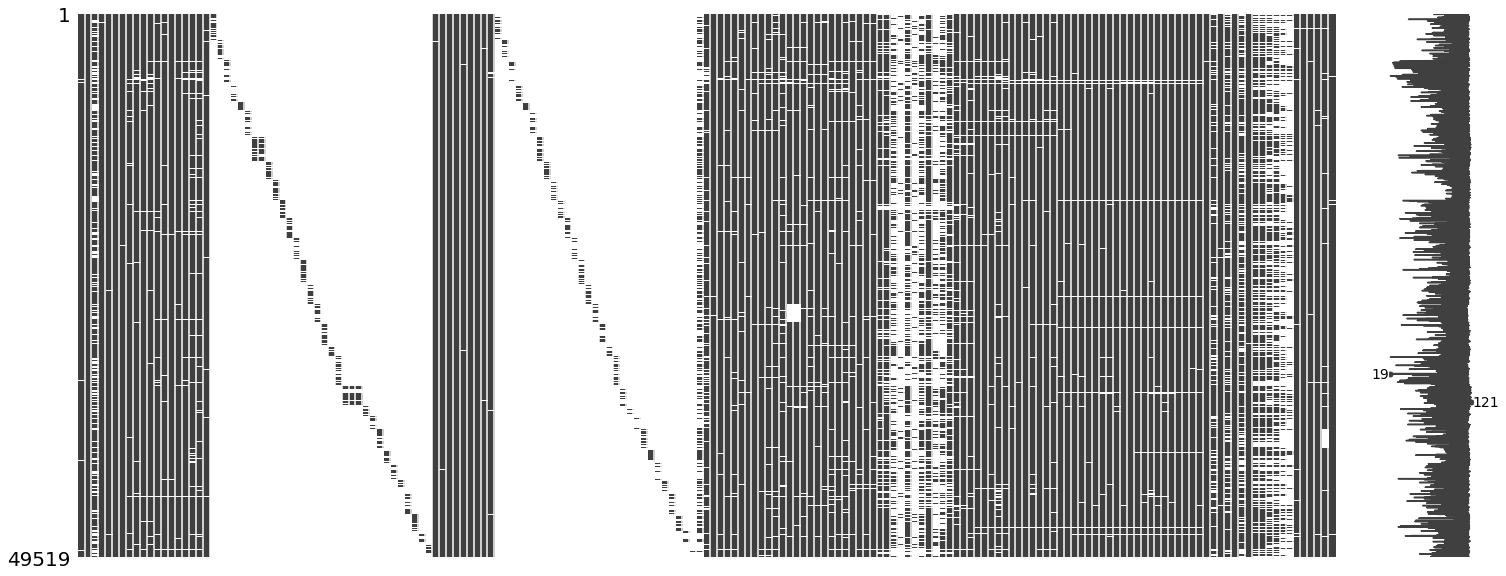

In [14]:
# Views and saves a plot of missing values
msno.matrix(df_final)
#plt.savefig("../../output/plots/missing_values.png", dpi = 400)

It appears there are certain columns with tons of systematically missing data. Based on the columns selected, these are the columns with country-specific values within the Politics theme. These will be removed.

In [15]:
# Removes country-specific columns
drop_cols = np.concatenate([np.arange(19,51), np.arange(60,89)])
df_final.drop(df_final.columns[drop_cols], axis = 1, inplace = True)

C:\Users\Matt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<AxesSubplot:>

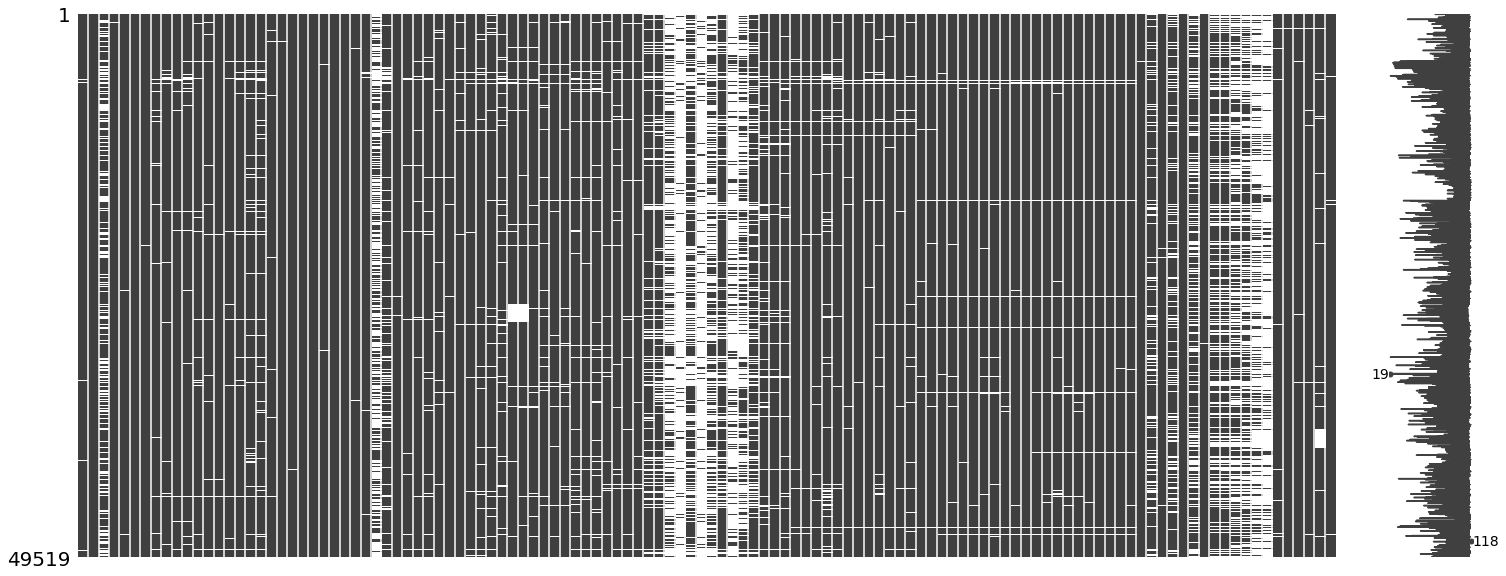

In [16]:
# Looks again at missing values
msno.matrix(df_final)

No other values appear to be systematically missing. Lets see how many missing values there are in the most sparse columns.

In [17]:
# Columns with the most missing data
df_final.isnull().sum().sort_values(ascending = False)[0:23]

grsplet    46177
netilet    45149
ggchld     42141
frlgrsp    37527
ygcdbyr    34396
grspnum    31248
prtdgcl    28233
frlneti    25732
ycldbyr    25052
grspfr     24564
ngchld     23631
netinum    16682
maryr      16311
fcldbrn    15303
netustm    15080
nbthcld    14919
lvptnyr    10909
occinfr     9394
pdempyr     8769
netifr      7942
lrscale     7250
infqbst     7179
fvgabc      5508
dtype: int64

Most missing columns seem to relate to people not having children or grandchildren, but all observations with missing values will need to be removed eventually. As such, all columns with more than ~10% (5000) of values missing will be dropped, this way we won't later systematically remove people without children.

In [18]:
# Finds column names with many missing values
drop_cols = np.array(df_final.isnull().sum().sort_values(ascending = False)[0:23].keys())

In [19]:
# Removes sparse columns
df_final = df_final.drop(drop_cols, axis = 1)

<AxesSubplot:>

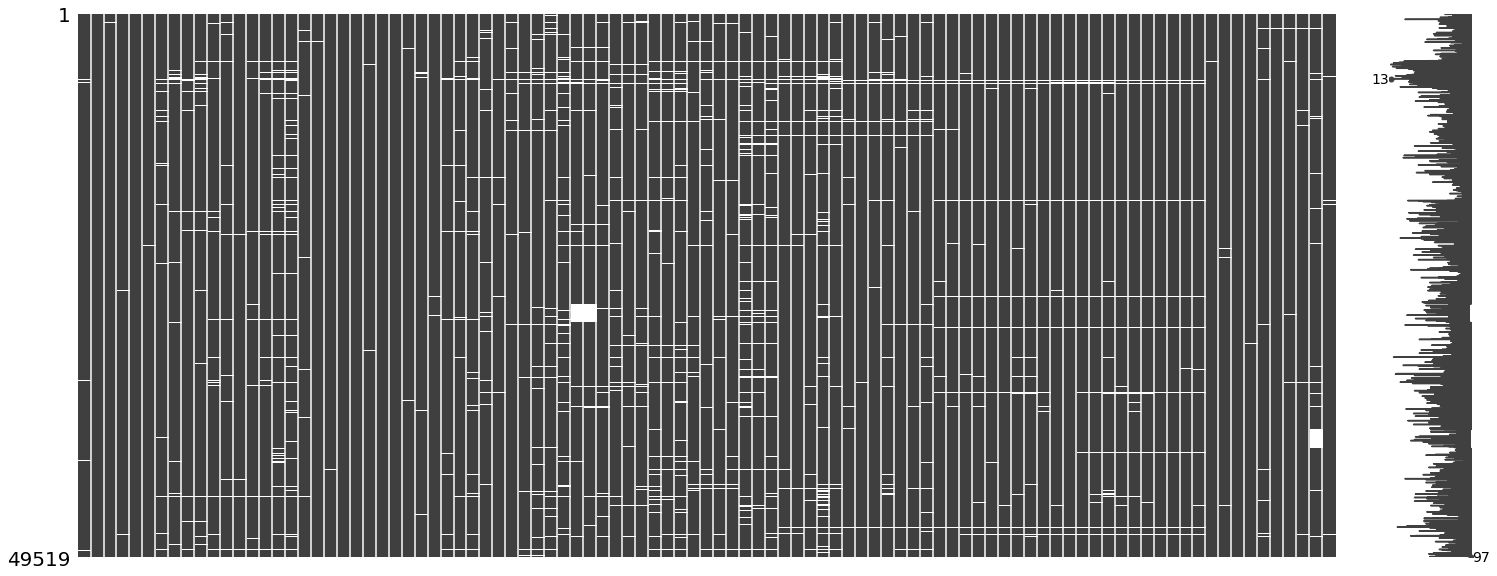

In [20]:
# Final review of missing values before removing ovservations
msno.matrix(df_final)
#plt.savefig("../../output/plots/missing_values_after.png", dpi = 400)

In [21]:
# Check number of remaining columns
len(df_final.columns)

97

## Outliers

In [22]:
# Determines quartiles and interquartile range
Q1 = df_final.quantile(0.25)
Q3 = df_final.quantile(0.75)
IQR = Q3 - Q1

In [23]:
# Number of columns containing outliers
len(df_final.columns[((df_final < (Q1 - 1.5 * IQR)) | (df_final > (Q3 + 1.5 * IQR))).sum() > 0])

34

In [24]:
# List of columns containing outliers
df_final.columns[((df_final < (Q1 - 1.5 * IQR)) | (df_final > (Q3 + 1.5 * IQR))).sum() > 0]

Index(['nwspol', 'trstplc', 'trstplt', 'trstprt', 'contplt', 'wrkprty',
       'wrkorg', 'badge', 'sgnptit', 'pbldmn', 'bctprd', 'pstplonl', 'stflife',
       'frprtpl', 'gvintcz', 'poltran', 'ifredu', 'evfredu', 'topinfr',
       'btminfr', 'recskil', 'recexp', 'sofrwrk', 'sofrpr', 'ipcrtiv',
       'ipudrst', 'ipmodst', 'ipbhprp', 'iplylfr', 'evpdemp', 'evlvptn',
       'alvgptn', 'acldnmr', 'aftjbyc'],
      dtype='object')

In [25]:
# Description of a single column with outliers
df_final["acldnmr"].describe()

count    48913.000000
mean         3.609613
std          1.068157
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: acldnmr, dtype: float64

In [26]:
# Outlier values in the news consumption feature
df_final["nwspol"].loc[df_final["nwspol"] > 1000]

2527     1057.0
2563     1058.0
2601     1050.0
2634     1170.0
2644     1202.0
          ...  
41913    1040.0
42097    1080.0
42395    1007.0
46219    1200.0
46463    1200.0
Name: nwspol, Length: 262, dtype: float64

## Drop Missing Values

In [27]:
# Drop missing values
df_final = df_final.dropna()

In [28]:
df_final.head()

,nwspol,netusoft,ppltrst,pplfair,pplhlp,polintr,psppsgva,actrolga,psppipla,cptppola,...,evpdemp,evlvptn,evmar,bthcld,anvcld,alvgptn,acldnmr,aftjbyc,advcyc,plnftr
0,60.0,5.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0,2.0
1,10.0,5.0,7.0,8.0,7.0,2.0,3.0,2.0,3.0,2.0,...,1.0,1.0,1.0,1.0,4.0,4.0,4.0,2.0,2.0,4.0
2,60.0,4.0,5.0,7.0,7.0,4.0,2.0,1.0,3.0,2.0,...,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,2.0
4,30.0,1.0,5.0,8.0,4.0,2.0,1.0,1.0,1.0,3.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,7.0
5,45.0,2.0,8.0,7.0,6.0,2.0,2.0,2.0,3.0,2.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2.0,4.0,2.0,3.0


## Scaling

In [29]:
# Initialize a standard scaler object
scaler = RobustScaler()

In [30]:
# Scale the data
df_final = pd.DataFrame(scaler.fit_transform(df_final),
                  columns=df_final.columns)

In [31]:
# Initialize a standard scaler object
scaler = RobustScaler()

# PCA

In [32]:
# Initialize a PCA object
pca = PCA(n_components=10)

In [33]:
# Fit the model
mod = pca.fit(df_final)

In [34]:
# Get loadings with items
loads = pd.DataFrame(mod.components_.T,
            index=df_final.columns)

In [35]:
# Finds features for principal components
pc1_keys = loads[0].sort_values()[[1,2,3,4,5,-5, -4,-3,-2,-1]].keys()
pc2_keys = loads[1].sort_values()[[1,2,3,4,5,-5, -4,-3,-2,-1]].keys()
pc3_keys = loads[2].sort_values()[[1,2,3,4,5,-5, -4,-3,-2,-1]].keys()
pc4_keys = loads[3].sort_values()[[1,2,3,4,5,-5, -4,-3,-2,-1]].keys()
pc5_keys = loads[4].sort_values()[[1,2,3,4,5,-5, -4,-3,-2,-1]].keys()

In [36]:
# Unique, important keys
pc_keys = list(set(np.concatenate([np.array(pc1_keys), np.array(pc2_keys), np.array(pc3_keys), np.array(pc4_keys),
                                   np.array(pc5_keys)])))

In [37]:
pc_keys

['psppipla',
 'freehms',
 'ifredu',
 'imwbcnt',
 'impcntr',
 'netusoft',
 'anvcld',
 'imdfetn',
 'vote',
 'stfdem',
 'iplylfr',
 'ipudrst',
 'imbgeco',
 'nwspol',
 'impsafe',
 'impenv',
 'advcyc',
 'gvintcz',
 'imsmetn',
 'poltran',
 'imprich',
 'recimg',
 'stfeco',
 'plnftr',
 'psppsgva',
 'hmsfmlsh',
 'trstprt',
 'ipbhprp',
 'clsprty',
 'ipmodst',
 'ipcrtiv',
 'polintr',
 'btminfr',
 'ipadvnt']

In [38]:
# renaming dictionary for key variables
# Sourced from the data protocols pdf
col_names = {'impcntr':"poor_immigrants", 'imueclt':"culture_immigrants", 'ipmodst':"modesty_humble", 'impenv':"environment", 'anvcld':"childfree", 
             'psppsgva':"have_say_in_gov", 'ipbhprp':"behave_properly", 'nwspol':"time_pol_news", 'imprich':"materialism", 'ipcrtiv':'creativity', 
             'poltran':"pol_transparency_exists", 'clsprty':"partisanship", 'polintr':"interest_in_pol", 'sofrwrk':"hard_work_pays", 'netusoft':"internet_use",
             'ifredu':"fair_access_edu", 'euftf':"euro_unification", 'hmsacld':"lgbt_adopt", 'psppipla':"have_say_in_pol", 'stfgov':"nat_gov", 'trstprt':"trust_parties", 
             'btminfr':"unfair_earnings_bot10", 'sofrpr':"care_for_poor", 'freehms':"free_lgbt", 'imbgeco':"immigr_good_for_econ", 'iplylfr':"loyalty",
             'ipadvnt':"adventure", 'imwbcnt':"immigr_make_cntry_bttr", 'ipudrst':"good_2_understand_diff_ppl", 'stfdem':"satis_democracy", "hmsfmlsh":"lgbt_family_ashamed",
             'gvintcz':"gov_cares_4_all", 'imsmetn':"majority_immigrants", 'impsafe':"safety", 'advcyc':"divorce_w_children", 'imdfetn':"minority_immigrants", 
             'aftjbyc':"full_job_&_kids", "stfeco":"satis_econ", "sofrdst":"prefer_eql_wealth_dist", "alvgptn":"approve_living_w_non_spouse"}
loads = loads.rename(col_names, axis = 0)

In [39]:
# PC1's most important features
pc1 = loads[0].sort_values()[[0,1,2,3,4,-5,-4,-3,-2,-1]].rename("Conservatism")
pc1

internet_use          -0.228390
have_say_in_pol       -0.206865
free_lgbt             -0.203236
satis_democracy       -0.190982
have_say_in_gov       -0.190127
behave_properly        0.061837
modesty_humble         0.068457
lgbt_family_ashamed    0.101314
safety                 0.102056
interest_in_pol        0.122278
Name: Conservatism, dtype: float64

**Disenfranchised** (politics/democracy/gov influence), **less internet**, **social conservative** (lgbt/safety).

Older conservatives, perhaps?

In [40]:
# PC2's most important features
pc2 = loads[1].sort_values()[[0,1,2,3,4,-5, -4,-3,-2,-1]].rename("News Consumption")
pc2

internet_use                 -0.074396
interest_in_pol              -0.070466
partisanship                 -0.024928
fair_access_edu              -0.022128
vote                         -0.021389
good_2_understand_diff_ppl    0.027448
immigr_good_for_econ          0.027840
modesty_humble                0.037195
behave_properly               0.045244
time_pol_news                 0.984729
Name: News Consumption, dtype: float64

**News** Consumption.

In [41]:
# PC3's most important features
pc3 = loads[2].sort_values()[[0,1,2,3,4,-5, -4,-3,-2,-1]].rename("Liberalism")
pc3

nat_gov                   -0.225301
pol_transparency_exists   -0.188415
satis_democracy           -0.187468
gov_cares_4_all           -0.180367
trust_parties             -0.176665
poor_immigrants            0.173958
divorce_w_children         0.241309
childfree                  0.254478
free_lgbt                  0.256960
internet_use               0.284180
Name: Liberalism, dtype: float64

**Social liberalism** (lgbt/families/immigrants), **distrustful** (transparency/trust/care), & **internet**.

In [42]:
# PC4's most important features
pc4 = loads[3].sort_values()[[0,1,2,3,4,-5, -4,-3,-2,-1]].rename("Individualism")
pc4

behave_properly              -0.406789
safety                       -0.396290
modesty_humble               -0.356767
good_2_understand_diff_ppl   -0.303386
environment                  -0.286272
plnftr                        0.034145
recimg                        0.034446
divorce_w_children            0.053532
unfair_earnings_bot10         0.061747
time_pol_news                 0.077211
Name: Individualism, dtype: float64

Social **Individualist** (anti-safety/humility/understanding/loyalty)

In [43]:
# PC5's most important features
pc5 = loads[4].sort_values()[[0,1,2,3,4,-5,-4,-3,-2,-1]].rename("Materialism")
pc5

modesty_humble           -0.245500
poor_immigrants          -0.179505
minority_immigrants      -0.175150
majority_immigrants      -0.138650
immigr_make_cntry_bttr   -0.137544
adventure                 0.196012
fair_access_edu           0.201444
creativity                0.258654
internet_use              0.334299
materialism               0.507970
Name: Materialism, dtype: float64

**Materialist** (anti-modesty, focused on becoming rich)

**Others:**

6. Order, Anti-Immigrant, Socially Liberal otherwise
7. Will Achieve Education Desired
8. Materialist, Pro-Immigrant, Order
9. Anti-Internet Usage
10. Politically active, disenfranchised, individualist

In [44]:
# Get loadings with items
df_load = pd.DataFrame(mod.components_.T,
                       index=df_final.columns).loc[pc_keys].rename(col_names, 
                                                                   axis = 0).sort_values(by = 0, 
                                                                                         ascending = False).style.background_gradient(cmap='seismic')

In [45]:
# % of variance explained by each component
pd.DataFrame(np.round(mod.explained_variance_ratio_, 2)*100,
            index=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"]).T

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,13.0,8.0,6.0,6.0,4.0,3.0,3.0,3.0,2.0,2.0


50% of variance explained in 10. 37% explained in first 5.

## Number of Components

In [46]:
# Initialize a PCA object
pca = PCA(n_components=97)

In [47]:
# Fit the model
mod = pca.fit(df_final)

In [48]:
# Build df with number of components and explained variance
pc_df = pd.DataFrame(mod.explained_variance_ratio_,
                             index=np.arange(pca.n_components_) + 1,
                             columns=["Variance Explained by Component (%)"])

In [49]:
# Reset index, rename components (for plotting w/ altair)
pc_df = pc_df.reset_index()

In [50]:
# rename the index column
pc_df = pc_df.rename(columns={"index":"Component"})

In [51]:
# Adds a cumulative sum axis
pc_df['Total Variance Explained (%)']=pc_df['Variance Explained by Component (%)'].cumsum(axis = 0) 

In [52]:
# Create scree plot with altair, elbow at 3
alt.Chart(pc_df).mark_line().encode(x="Component",
                                    y="Variance Explained by Component (%)").interactive()

alt.Chart(...)

(0.0, 100.0)

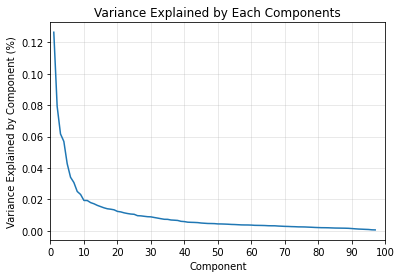

In [53]:
# Visualize scree plot using seaborn
sns.lineplot(x = "Component",
            y = "Variance Explained by Component (%)",
            data=pc_df)
plt.title("Variance Explained by Each Components")
plt.grid(alpha = 0.35)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.xlim(0,100)
#plt.savefig("../../output/plots/scree_plot.png", dpi = 400)

<AxesSubplot:xlabel='Component', ylabel='Total Variance Explained (%)'>

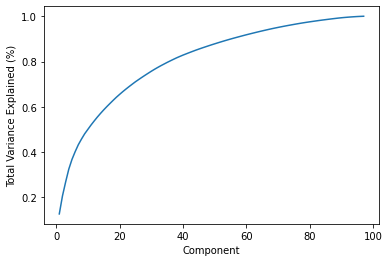

In [54]:
# Create a plot of the total variance explained, with seaborn
sns.lineplot(x = "Component",
            y = "Total Variance Explained (%)",
            data=pc_df)

In [55]:
# total variance explained given all features
np.sum(np.round(mod.explained_variance_ratio_, 2)*100)

90.0